# NBA STAR PLAYER OFFENSIVE ROLE CLUSTERING (TOP 25)

## IMPORTING DATA & LIBRARIES

In [1]:
# nba data
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.endpoints import leaguedashplayerptshot

# packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn

# scikit
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import decomposition

In [2]:
# Pull data for the top 100 scorers by PTS column
top_100 = leagueleaders.LeagueLeaders(
    season='2022-23',
    season_type_all_star='Regular Season',
    stat_category_abbreviation='PTS'
).get_data_frames()[0][:100]
top_100

,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,1628369,1,Jayson Tatum,1610612738,BOS,74,2732,727,1559,0.466,...,649,342,78,51,213,160,2225,2209,1.61,0.37
1,203954,2,Joel Embiid,1610612755,PHI,66,2284,728,1328,0.548,...,670,274,66,112,226,205,2183,2369,1.21,0.29
2,1629029,3,Luka Doncic,1610612742,DAL,66,2391,719,1449,0.496,...,569,529,90,33,236,166,2138,2214,2.24,0.38
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,2416,704,1381,0.510,...,329,371,112,65,192,192,2135,2073,1.93,0.58
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,2024,707,1278,0.553,...,742,359,52,51,246,197,1959,2072,1.46,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1628401,96,Derrick White,1610612738,BOS,82,2319,350,758,0.462,...,293,321,54,76,95,177,1017,1234,3.38,0.57
96,1629652,97,Luguentz Dort,1610612760,OKC,74,2272,339,873,0.388,...,344,154,75,23,92,243,1013,924,1.67,0.81
97,1631095,98,Jabari Smith Jr.,1610612745,HOU,79,2451,364,892,0.408,...,569,101,43,74,104,227,1010,1121,0.97,0.41
98,1627763,99,Malcolm Brogdon,1610612738,BOS,67,1744,354,732,0.484,...,280,248,45,18,98,109,1000,1091,2.53,0.46


## EDA

In [3]:
# get rid of players not meeting gp criteria, removes outliers
score_df = top_100[top_100['GP'] > 50]
score_df

,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,1628369,1,Jayson Tatum,1610612738,BOS,74,2732,727,1559,0.466,...,649,342,78,51,213,160,2225,2209,1.61,0.37
1,203954,2,Joel Embiid,1610612755,PHI,66,2284,728,1328,0.548,...,670,274,66,112,226,205,2183,2369,1.21,0.29
2,1629029,3,Luka Doncic,1610612742,DAL,66,2391,719,1449,0.496,...,569,529,90,33,236,166,2138,2214,2.24,0.38
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,2416,704,1381,0.510,...,329,371,112,65,192,192,2135,2073,1.93,0.58
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,2024,707,1278,0.553,...,742,359,52,51,246,197,1959,2072,1.46,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1628401,96,Derrick White,1610612738,BOS,82,2319,350,758,0.462,...,293,321,54,76,95,177,1017,1234,3.38,0.57
96,1629652,97,Luguentz Dort,1610612760,OKC,74,2272,339,873,0.388,...,344,154,75,23,92,243,1013,924,1.67,0.81
97,1631095,98,Jabari Smith Jr.,1610612745,HOU,79,2451,364,892,0.408,...,569,101,43,74,104,227,1010,1121,0.97,0.41
98,1627763,99,Malcolm Brogdon,1610612738,BOS,67,1744,354,732,0.484,...,280,248,45,18,98,109,1000,1091,2.53,0.46


In [4]:
# keep only top 25 scorers 
top_25 = score_df.head(n=25)
top_25.head()

,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,1628369,1,Jayson Tatum,1610612738,BOS,74,2732,727,1559,0.466,...,649,342,78,51,213,160,2225,2209,1.61,0.37
1,203954,2,Joel Embiid,1610612755,PHI,66,2284,728,1328,0.548,...,670,274,66,112,226,205,2183,2369,1.21,0.29
2,1629029,3,Luka Doncic,1610612742,DAL,66,2391,719,1449,0.496,...,569,529,90,33,236,166,2138,2214,2.24,0.38
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,2416,704,1381,0.510,...,329,371,112,65,192,192,2135,2073,1.93,0.58
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,2024,707,1278,0.553,...,742,359,52,51,246,197,1959,2072,1.46,0.21


In [5]:
# make col names lowercase
top_25.columns = map(str.lower, top_25.columns)
top_25.columns

Index(['player_id', 'rank', 'player', 'team_id', 'team', 'gp', 'min', 'fgm',
       'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'eff',
       'ast_tov', 'stl_tov'],
      dtype='object')

In [6]:
# create new dataframe with player names only then drop in other dataframe so that kmeans can be performed
names_teams = top_25[['player','team']]
names_teams.head()

,player,team
0,Jayson Tatum,BOS
1,Joel Embiid,PHI
2,Luka Doncic,DAL
3,Shai Gilgeous-Alexander,OKC
4,Giannis Antetokounmpo,MIL


In [7]:
# drop columns to create df of offensive stats
top_25_off = top_25.drop(columns=['player_id', 'rank','team_id','gp','min','dreb','reb','stl', 'blk','pf','stl_tov','player', 'team'])
top_25_off.head()

,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,ast,tov,pts,eff,ast_tov
0,727,1559,0.466,240,686,0.350,531,622,0.854,78,342,213,2225,2209,1.61
1,728,1328,0.548,66,200,0.330,661,771,0.857,113,274,226,2183,2369,1.21
2,719,1449,0.496,185,541,0.342,515,694,0.742,54,529,236,2138,2214,2.24
3,704,1381,0.510,58,168,0.345,669,739,0.905,59,371,192,2135,2073,1.93
4,707,1278,0.553,47,171,0.275,498,772,0.645,137,359,246,1959,2072,1.46


## Preprocessing

In [8]:
# identify numeric features
numeric_features = top_25_off.columns.tolist()

# create numeric transformer
numeric_transformer = StandardScaler()

# create column transformer
scaler = make_column_transformer((numeric_transformer,numeric_features))

# scale data
scale = scaler.fit_transform(top_25_off)


# to df
top_25_scaled = pd.DataFrame(scale, columns = numeric_features)
top_25_scaled.head()

,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,ast,tov,pts,eff,ast_tov
0,1.499711,2.022277,-0.538715,1.211646,1.404320,-0.067908,1.120201,0.943876,0.419946,0.122497,-0.299812,0.355922,2.092481,1.315222,-0.622342
1,1.516516,0.156678,1.371952,-1.334566,-1.364217,-0.653320,2.220096,1.974943,0.463996,1.030843,-0.835192,0.655598,1.869243,1.832059,-1.363225
2,1.365268,1.133896,0.160310,0.406809,0.578317,-0.302073,0.984829,1.442110,-1.224597,-0.500369,1.172481,0.886117,1.630060,1.331373,0.544549
3,1.113187,0.584716,0.486521,-1.451633,-1.546507,-0.214261,2.287782,1.753506,1.168800,-0.370605,-0.071489,-0.128169,1.614114,0.875910,-0.029635
4,1.163603,-0.247131,1.488456,-1.612601,-1.529417,-2.263202,0.840997,1.981863,-2.648888,1.653709,-0.165968,1.116637,0.678642,0.872680,-0.900173


## Elbow Method

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

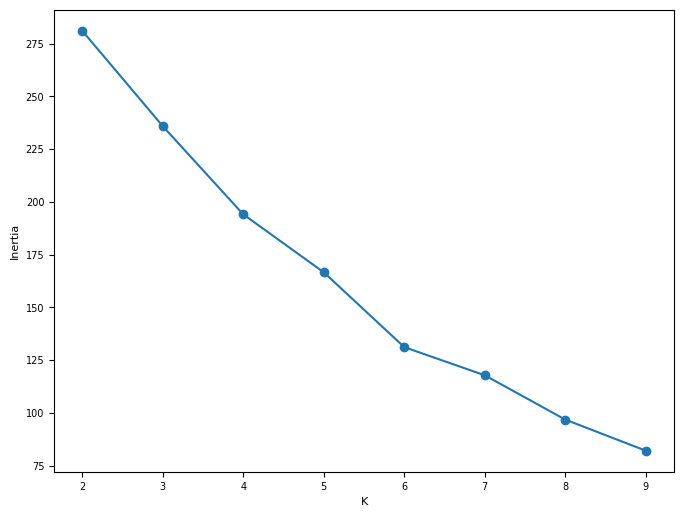

In [9]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.plot(range(2, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
inertia_values = list()
for k in range(2, 10):
    inertia_values.append(KMeans(n_clusters=k).fit(top_25_scaled).inertia_)
plot_elbow(8, 6, inertia_values)

### k =6

In [10]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(top_25_scaled)
pca_25_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])

# kmeans with principal components
kmeans_top_25 = KMeans(random_state=22, n_clusters=6)
kmeans_fit = kmeans_top_25.fit(pca_25_df)

# add predictions to dataframe
pca_25_df["cluster"] = kmeans_top_25.labels_
pca_25_df.head()

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PC1,PC2,cluster
0,1.941548,-3.406489,3
1,4.606517,-0.271522,1
2,2.837581,-1.508154,3
3,3.308390,-0.149729,1
4,4.664507,0.966758,1


In [11]:
# get variance explained by principal components
print(pca.explained_variance_ratio_.round(2)[:10])

[0.35 0.22]


In [12]:
# create final dataframe to visualize
off_25_final_df = pd.concat([names_teams,pca_25_df], axis=1)
off_25_final_df.head()

,player,team,PC1,PC2,cluster
0,Jayson Tatum,BOS,1.941548,-3.406489,3
1,Joel Embiid,PHI,4.606517,-0.271522,1
2,Luka Doncic,DAL,2.837581,-1.508154,3
3,Shai Gilgeous-Alexander,OKC,3.308390,-0.149729,1
4,Giannis Antetokounmpo,MIL,4.664507,0.966758,1


In [13]:
top_25_kmeans_graph = alt.Chart(off_25_final_df,title= 'NBA Top 25 Scorers Offensive Roles Kmeans Clustering (K=6)').mark_point(
).encode(alt.X('PC1',title ='Principal Component 1 (35%)'),
         alt.Y('PC2',title = 'Principal Component 2 (22%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('player'),
                   alt.Tooltip('team')])

top_25_kmeans_graph

alt.Chart(...)